In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpr1mpgr95


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
# data_dir = "/dataset/"
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


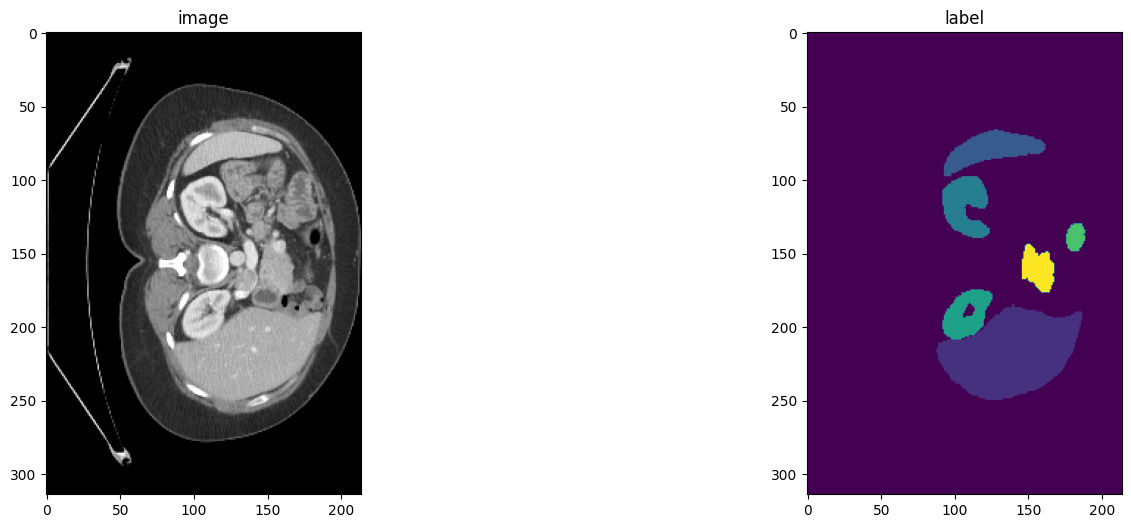

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [18]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    #載入預訓練權重
    pretrained_dict=torch.load('/home/user/Documents/unetr/UNETR_model_best_acc.pth')#預訓練參數
    model_dict = model.state_dict()#當前網路參數
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict and "out.conv.conv" not in k)}
    #濾掉當前網路所沒有層的參數 且忽略最後輸出的卷積層
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) #更新
    # 3. load the new state dict
    model.load_state_dict(model_dict) #載入過濾後的權重
#     model.load_state_dict(torch.load('/home/user/Documents/unetr/UNETR_model_best_acc.pth'))
#     model = torch.load('/home/user/Documents/unetr/UNETR_model_best_acc.pth')
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=2.02559):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21/24 [00:11<00:05,  1.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.34451499581336975 Current Avg. Dice: 0.34451499581336975


Training (1000 / 25000 Steps) (loss=1.57367):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:09<00:11,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.34451499581336975 Current Avg. Dice: 0.3344959020614624


Training (1500 / 25000 Steps) (loss=1.31963):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:09<00:18,  1.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.34733572602272034 Current Avg. Dice: 0.34733572602272034


Training (2000 / 25000 Steps) (loss=1.40069):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:07<00:24,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.34733572602272034 Current Avg. Dice: 0.34415969252586365


Training (2500 / 25000 Steps) (loss=1.19199):  21%|█████████████████████████▏                                                                                               | 5/24 [00:06<00:37,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.34733572602272034 Current Avg. Dice: 0.2841086983680725


Training (3000 / 25000 Steps) (loss=1.18313):   4%|█████                                                                                                                    | 1/24 [00:05<02:12,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.34733572602272034 Current Avg. Dice: 0.2366732507944107


Training (3500 / 25000 Steps) (loss=0.99143):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:10<00:05,  1.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6886715888977051 Current Avg. Dice: 0.6886715888977051


Training (4000 / 25000 Steps) (loss=0.89692):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:09<00:11,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7229054570198059 Current Avg. Dice: 0.7229054570198059


Training (4500 / 25000 Steps) (loss=0.84378):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:08<00:18,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7741071581840515 Current Avg. Dice: 0.7741071581840515


Training (5000 / 25000 Steps) (loss=0.93958):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:07<00:26,  1.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8015143871307373 Current Avg. Dice: 0.8015143871307373


Training (5500 / 25000 Steps) (loss=0.70566):  21%|█████████████████████████▏                                                                                               | 5/24 [00:06<00:36,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8015143871307373 Current Avg. Dice: 0.7874622941017151


Training (6000 / 25000 Steps) (loss=0.71897):   4%|█████                                                                                                                    | 1/24 [00:05<02:08,  5.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8015143871307373 Current Avg. Dice: 0.7780807614326477


Training (6500 / 25000 Steps) (loss=0.69146):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:10<00:04,  1.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8015143871307373 Current Avg. Dice: 0.801389753818512


Training (7000 / 25000 Steps) (loss=0.71031):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:09<00:11,  1.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8137684464454651 Current Avg. Dice: 0.8137684464454651


Training (7500 / 25000 Steps) (loss=0.66973):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:08<00:18,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8323867321014404 Current Avg. Dice: 0.8323867321014404


Training (8000 / 25000 Steps) (loss=0.57351):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:07<00:26,  1.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8798947930335999 Current Avg. Dice: 0.8798947930335999


Training (8500 / 25000 Steps) (loss=0.88303):  21%|█████████████████████████▏                                                                                               | 5/24 [00:06<00:36,  1.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8798947930335999 Current Avg. Dice: 0.8646077513694763


Training (9000 / 25000 Steps) (loss=0.71051):   4%|█████                                                                                                                    | 1/24 [00:05<02:08,  5.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8798947930335999 Current Avg. Dice: 0.8234384655952454


Training (9500 / 25000 Steps) (loss=0.74933):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:10<00:05,  1.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.9059426784515381


Training (10000 / 25000 Steps) (loss=0.57321):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8944277763366699


Training (10500 / 25000 Steps) (loss=0.61661):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:17,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.9054739475250244


Training (11000 / 25000 Steps) (loss=0.67245):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:24,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.9000404477119446


Training (11500 / 25000 Steps) (loss=0.67067):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:36,  1.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8854014277458191


Training (12000 / 25000 Steps) (loss=0.53143):   4%|█████                                                                                                                   | 1/24 [00:05<02:12,  5.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8622627854347229


Training (12500 / 25000 Steps) (loss=0.61586):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8936495780944824


Training (13000 / 25000 Steps) (loss=0.60107):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.861406147480011


Training (13500 / 25000 Steps) (loss=1.19441):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:17,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.9022905230522156


Training (14000 / 25000 Steps) (loss=0.58084):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:25,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8865416646003723


Training (14500 / 25000 Steps) (loss=0.79445):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:37,  1.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8828250765800476


Training (15000 / 25000 Steps) (loss=0.76377):   4%|█████                                                                                                                   | 1/24 [00:05<02:13,  5.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.8343803286552429


Training (15500 / 25000 Steps) (loss=0.64426):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9059426784515381 Current Avg. Dice: 0.9026947617530823


Training (16000 / 25000 Steps) (loss=0.69121):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:10<00:11,  1.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9098544120788574 Current Avg. Dice: 0.9098544120788574


Training (16500 / 25000 Steps) (loss=0.57065):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:17,  1.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9098544120788574 Current Avg. Dice: 0.9032201170921326


Training (17000 / 25000 Steps) (loss=0.45139):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:26,  1.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9109344482421875


Training (17500 / 25000 Steps) (loss=0.52283):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:37,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.8687049746513367


Training (18000 / 25000 Steps) (loss=0.56440):   4%|█████                                                                                                                   | 1/24 [00:05<02:12,  5.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.860467255115509


Training (18500 / 25000 Steps) (loss=0.76109):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9065822958946228


Training (19000 / 25000 Steps) (loss=0.86587):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9065235257148743


Training (19500 / 25000 Steps) (loss=0.67382):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:17,  1.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.8977632522583008


Training (20000 / 25000 Steps) (loss=1.31967):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:25,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9100961685180664


Training (20500 / 25000 Steps) (loss=0.58534):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:36,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9055149555206299


Training (21000 / 25000 Steps) (loss=0.64305):   4%|█████                                                                                                                   | 1/24 [00:05<02:13,  5.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.8699234127998352


Training (21500 / 25000 Steps) (loss=0.78263):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.8584610819816589


Training (22000 / 25000 Steps) (loss=0.60582):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9107345938682556


Training (22500 / 25000 Steps) (loss=0.77234):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:08<00:18,  1.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.896579921245575


Training (23000 / 25000 Steps) (loss=0.64780):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:07<00:24,  1.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.8962990641593933


Training (23500 / 25000 Steps) (loss=0.65319):  21%|█████████████████████████                                                                                               | 5/24 [00:06<00:36,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.885648250579834


Training (24000 / 25000 Steps) (loss=0.53437):   4%|█████                                                                                                                   | 1/24 [00:05<02:14,  5.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.8526328206062317


Training (24500 / 25000 Steps) (loss=0.71634):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:10<00:04,  1.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.9067186713218689


Training (25000 / 25000 Steps) (loss=0.69321):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:09<00:11,  1.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9109344482421875 Current Avg. Dice: 0.904176652431488


Training (25007 / 25000 Steps) (loss=0.75416): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.08it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpr1mpgr95/best_metric_model.pth'

In [19]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.9109 at iteration: 17000


In [20]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpr1mpgr95/best_metric_model.pth'